In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/nlp_teknofest/kaan

/content/drive/My Drive/nlp_teknofest/kaan


In [ ]:
!pip install keras

In [ ]:
!pip install flair

In [ ]:
!pip install tensorflow

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint;
from keras.layers import Conv1D, MaxPooling1D, Flatten;
from keras.optimizers import Adam;
from keras.regularizers import l2;

In [7]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Bidirectional, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import flair
from flair.data import Sentence
from flair.models import SequenceTagger
import re
from gensim.utils import simple_preprocess
# Flair NER modelini yükleme
nlp_flair = SequenceTagger.load("flair/ner-multi")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

2024-08-08 17:43:22,710 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>


In [9]:
def extract_entities(text):
    sentence = Sentence(text)
    nlp_flair.predict(sentence)
    entities = [entity.text for entity in sentence.get_spans('ner')]
    return entities

def prepare_data(data):
    texts = data['Text'].astype(str).values
    entities = data['Entities'].apply(eval).values
    sentiments = data['Sentiments'].apply(eval).values
    return texts, entities, sentiments



def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # HTML etiketlerini kaldır
    text = re.sub(r'http\S+|www\S+|@\S+', ' ', text)  # URL'leri ve kullanıcı adlarını kaldır
    text = re.sub(r'\d+', ' ', text)  # Sayıları kaldır
    text = re.sub(r'[^\w\s]', ' ', text)  # Noktalama işaretlerini kaldır
    text = re.sub(r'\s+', ' ', text).strip()  # Fazla boşlukları kaldır ve baş/sondaki boşlukları temizle
    text = text.lower()  # Küçük harfe dönüştür
    return text

def preprocess_texts(texts):
    cleaned_texts = [clean_text(text) for text in texts]  # Metinleri temizle
    tokenized_texts = [simple_preprocess(text) for text in cleaned_texts]  # Metinleri tokenize et
    return tokenized_texts

def pad_sequences_custom(sequences, max_sequence_length):
    return pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32', value=0.0)


def prepare_labels(entities, sentiments, le):
    labels = []
    for entity_list, sentiment_list in zip(entities, sentiments):
        text_labels = np.zeros(len(le.classes_))
        for entity, sentiment in zip(entity_list, sentiment_list):
            if sentiment in le.classes_:
                index = le.transform([sentiment])[0]
                text_labels[index] = 1  # Label encoding
        labels.append(text_labels)
    return np.array(labels)

In [ ]:
!pip install openpyxl xlrd


In [10]:
# Veri setini yükleme
data = pd.read_csv('data5.xls')
#data = pd.read_excel('data5.xls', engine='xlrd')  # .xls dosyaları için 'xlrd'

# Veriyi hazırlama
texts, entities, sentiments = prepare_data(data)

# Metinleri ön işleme
tokenized_texts = preprocess_texts(texts)

In [ ]:
sentiments

In [ ]:
# Eksik değerleri kontrol edin
print(data.isnull().sum())

Text          0
Entities      0
Sentiments    0
dtype: int64


In [11]:
import pickle


In [ ]:
import pickle

# LabelEncoder'ı yükle KAYDEDİLENİ YÜKLE
with open('label_encoder.pkl', 'rb') as file:
    le = pickle.load(file)

In [12]:

# Etiketleri sayısal değerlere dönüştürme
le = LabelEncoder()
all_sentiments = [sent for sublist in sentiments for sent in sublist]
le.fit(all_sentiments)


LabelEncoder()

In [25]:
%cd /content/drive/My Drive/nlp_teknofest/kaan

/content/drive/My Drive/nlp_teknofest/kaan


In [26]:
# LabelEncoder'ı kaydet
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)


In [27]:
# Prepare labels for training
labels = prepare_labels(entities, sentiments, le)

In [28]:
labels

array([[0., 1., 1.],
       [1., 1., 1.],
       [0., 1., 1.],
       ...,
       [1., 0., 1.],
       [1., 1., 1.],
       [1., 0., 1.]])

In [35]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

#JSON dosyasından Tokenizer'ı yükleme
with open('tokenizer.json') as f:
    tokenizer_data = json.load(f) # Load JSON data from file

# 'tokenizer_data' is already a dictionary, so directly pass it to tokenizer_from_json
tokenizer = tokenizer_from_json(json.dumps(tokenizer_data)) # Convert dictionary to JSON string

sequences = tokenizer.texts_to_sequences(texts)

In [37]:
# Tokenizer kullanarak metinleri dizilere dönüştür
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Tokenizer'ı JSON formatında kaydetme
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)


# Metinleri dizilere dönüştür
max_length = 200
data_texts = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_length)


# Eğitim ve test setlerini belirli oranlarda böl
X_train, X_test, y_train, y_test = train_test_split(data_texts, labels, test_size=0.1, random_state=42)

print(f"Train data shape: {X_train.shape}")
print(f"Test  data shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (900, 200)
Test  data shape: (100, 200)
Train labels shape: (900, 3)
Test labels shape: (100, 3)


# **MultiBiGRU**

In [38]:
# Word2Vec modeli eğitme
embedding_dim = 300  # Skip Gram modeli için 300 boyutlu vektörler
word2vec_model = Word2Vec(sentences=[text.split() for text in texts],
                          vector_size=embedding_dim, window=5, sg=1, workers=8, min_count=1)

# Word2Vec modelinden embedding matrisi oluşturma
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [39]:
vocab_size

137

In [40]:
# Embedding matrisini bir dosyaya kaydetme
embedding_matrix_path = '/content/drive/My Drive/nlp_teknofest/kaan/embedding_matrix1.npy'
np.save(embedding_matrix_path, embedding_matrix)
print(f"Embedding matrisi {embedding_matrix_path} dosyasına kaydedildi.")

Embedding matrisi /content/drive/My Drive/nlp_teknofest/kaan/embedding_matrix1.npy dosyasına kaydedildi.


In [ ]:

embedding_matrix_path = '/content/drive/My Drive/nlp_teknofest/kaan/embedding_matrix1.npy'
embedding_matrix = np.load(embedding_matrix_path)
print(f"Embedding matrisi {embedding_matrix_path} dosyasından yüklendi.")


Embedding matrisi /content/drive/My Drive/nlp_teknofest/kaan/embedding_matrix1.npy dosyasından yüklendi.


In [41]:
num_filters = 128
num_units = 128
learning_rate = 0.0001
batch_size = 64
num_epochs = 20
recurrent_dropout = 0.3
output_size = len(le.classes_)

# Modelin tanımlanması
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))

# 6 tane Bidirectional GRU katmanı ekleme (hepsi return_sequences=True olmalı)
for i in range(3):
    model.add(Bidirectional(GRU(num_units, return_sequences=True, recurrent_dropout=recurrent_dropout)))

model.add(Conv1D(num_filters, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv1D(num_filters, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Sonuç katmanları
model.add(Flatten())  # Conv1D katmanının çıktısını düzleştir
model.add(Dense(num_units, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(output_size, activation='softmax'))

# Modelin derlenmesi
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [42]:
# Model checkpoint callback
checkpoint_path = '/content/drive/My Drive/nlp_teknofest/kaan/best_model.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

In [ ]:
# Model ağırlıklarını yükleme
model_weights_path = '/content/drive/My Drive/nlp_teknofest/kaan/best_model.keras'
try:
    model.load_weights(model_weights_path)
    print(f"Model ağırlıkları {model_weights_path} dosyasından yüklendi.")
except Exception as e:
    print(f"Ağırlıkları yüklerken bir hata oluştu: {e}")

Model ağırlıkları /content/drive/My Drive/nlp_teknofest/kaan/best_model.keras dosyasından yüklendi.


In [43]:
input_shape = (None, max_length)
model.build(input_shape)

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 300)            │          41,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 256)            │         330,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 198, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 196, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,718,095 (10.37 MB)

 Trainable params: 2,676,995 (10.21 MB)

 Non-trainable params: 41,100 (160.55 KB)

In [ ]:
# Modelin eğitilmesi
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.15,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

In [ ]:
# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.8766 - loss: nan
Test Accuracy: 0.8399999737739563


In [ ]:
# Metinden varlıkları çıkarma
text = "Vodafone ve Türk Telekom müşteri hizmetlerine ulaşmak çok zor, çok yetersizler."
entities = extract_entities(text)

# Varlıklar için etiketleme işlemi
def get_entity_sentiments(entities, tokenizer, model, max_length, le):
    # Tokenize ve pad işlemleri
    tokenized_entities = [simple_preprocess(entity) for entity in entities]
    sequences = tokenizer.texts_to_sequences(tokenized_entities)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Model ile tahmin yapma
    predictions = model.predict(padded_sequences)

    # Etiketleri döndürme
    predicted_classes = np.argmax(predictions, axis=-1)
    sentiments = le.inverse_transform(predicted_classes)

    return sentiments

# Varlıkların etiketlerini al
sentiments = get_entity_sentiments(entities, tokenizer, model, max_length, le)

# Her varlık için duygu analizi
for entity, sentiment in zip(entities, sentiments):
    print(f"Entity: {entity}, Sentiment: {sentiment}")


In [ ]:
def extract_entities(text):
    sentence = Sentence(text)
    nlp_flair.predict(sentence)
    entities = [entity.text for entity in sentence.get_spans('ner')]
    return entities

# Varlıklar için etiketleme işlemi
def get_entity_sentiments(entities, tokenizer, model, max_length, le):
    # Tokenize ve pad işlemleri
    tokenized_entities = [simple_preprocess(entity) for entity in entities]
    sequences = tokenizer.texts_to_sequences(tokenized_entities)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Model ile tahmin yapma
    predictions = model.predict(padded_sequences)

    # Etiketleri döndürme
    predicted_classes = np.argmax(predictions, axis=-1)
    sentiments = le.inverse_transform(predicted_classes)

    # Her sınıf için olasılıkları döndürme
    probabilities = np.max(predictions, axis=-1)

    return sentiments, probabilities

# Metinden varlıkları çıkarma
text = "Turkcell ve Vodofone internet hızları çok iyidir"
entities = extract_entities(text)

# Varlıkların etiketlerini ve olasılıklarını al
sentiments, probabilities = get_entity_sentiments(entities, tokenizer, model, max_length, le)

# Her varlık için duygu analizi ve olasılık
for entity, sentiment, probability in zip(entities, sentiments, probabilities):
    print(f"Entity: {entity}, Sentiment: {sentiment}, Probability: {probability:.2f}")

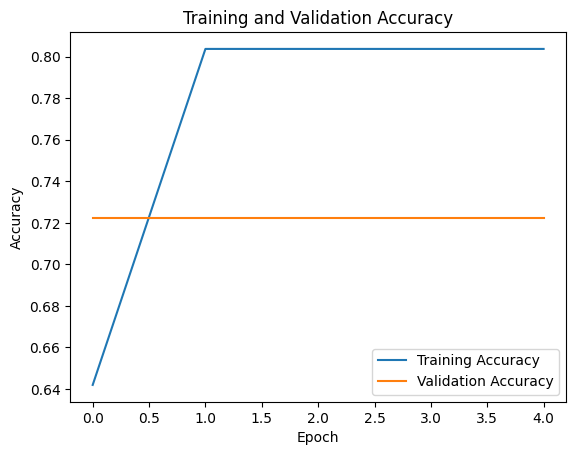

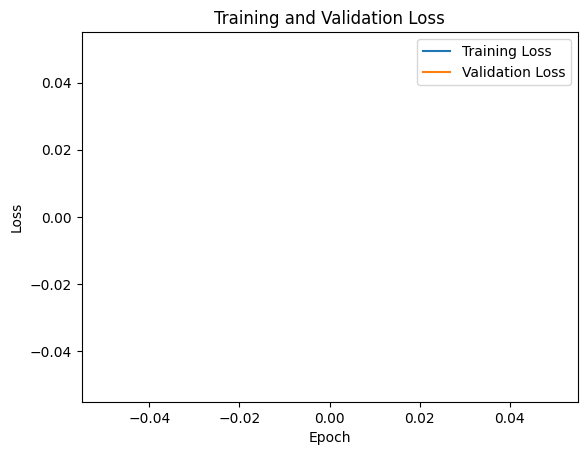

In [ ]:
import matplotlib.pyplot as plt

# Modelin eğitim süreci boyunca elde edilen doğruluk ve kayıp değerlerini alın
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Doğruluk grafiği
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Kayıp grafiği
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 636ms/step


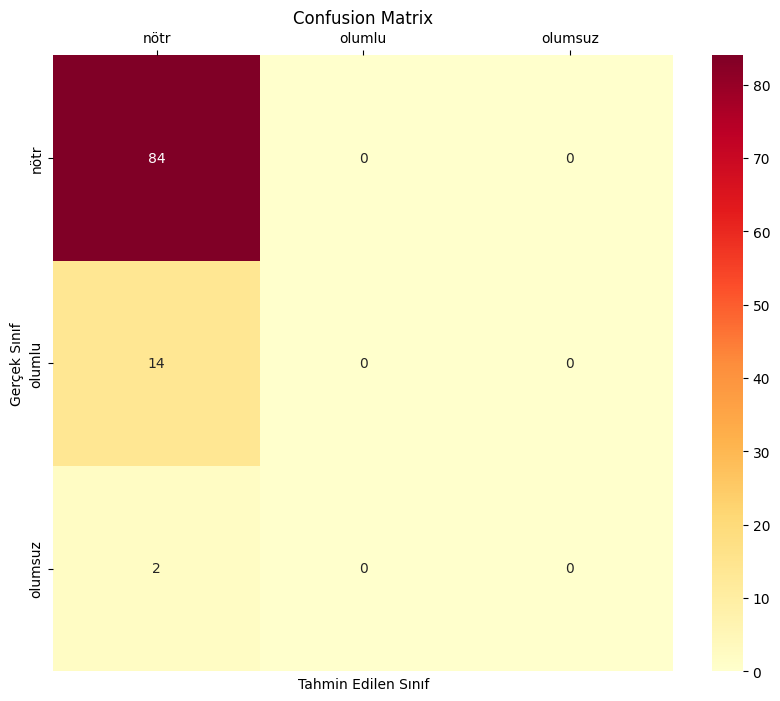

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Test verisi üzerinde tahminlerin yapılması
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Confusion matrix'in oluşturulması
cm = confusion_matrix(true_labels, predicted_labels)
class_names = le.classes_

# Görselleştirme
plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=class_names, yticklabels=class_names)
hm.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()
